# Imports and Setup

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
from datetime import datetime
import torch.nn.functional as F
import gc
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Add src directory to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✅ Device: cuda
   GPU: NVIDIA B200
   Memory: 191.51 GB


In [2]:
# Setup path to access custom modules
root_directory = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(root_directory, 'src'))

from ModelDataGenerator import build_dataloader

# GPU Memory Optimization

In [3]:
def clear_gpu_memory():
    """Clear GPU cache and garbage collect"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    print("✅ GPU memory cleared")

# Check initial GPU memory
if torch.cuda.is_available():
    initial_memory = torch.cuda.memory_allocated() / 1e9
    reserved_memory = torch.cuda.memory_reserved() / 1e9
    print(f"Initial GPU Memory Usage:")
    print(f"   Allocated: {initial_memory:.2f} GB")
    print(f"   Reserved: {reserved_memory:.2f} GB")
    print(f"   Total Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

clear_gpu_memory()

Initial GPU Memory Usage:
   Allocated: 0.00 GB
   Reserved: 0.00 GB
   Total Available: 191.51 GB
✅ GPU memory cleared


# DeepCNN Architecture (ResNet-style)

In [4]:
class ResidualBlock(nn.Module):
    """Residual block with skip connection"""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

In [5]:
class DeepCNN(nn.Module):
    """
    DeepCNN Architecture for medical image super-resolution
    Based on ResNet with residual blocks for skip connections
    
    Input: (B, 2, H, W) - prior and posterior slices
    Output: (B, 1, H, W) - predicted middle slice
    """
    def __init__(self, in_channels=2, out_channels=1, num_blocks=[2, 2, 2, 2], base_features=64):
        super(DeepCNN, self).__init__()
        
        self.base_features = base_features
        
        # Initial convolution
        self.conv1 = nn.Conv2d(in_channels, base_features, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_features)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(ResidualBlock, base_features, base_features, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(ResidualBlock, base_features, base_features * 2, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(ResidualBlock, base_features * 2, base_features * 4, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(ResidualBlock, base_features * 4, base_features * 8, num_blocks[3], stride=1)
        
        # Output layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.output_conv = nn.Conv2d(base_features * 8, out_channels, kernel_size=1)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(block(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Output
        x = self.output_conv(x)
        
        return x

print("✅ DeepCNN model defined")

✅ DeepCNN model defined


# Test Model

In [6]:
# Test model initialization
model = DeepCNN(in_channels=2, out_channels=1, num_blocks=[2, 2, 2, 2], base_features=64)
print(f"Model created successfully!")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
test_input = torch.randn(2, 2, 256, 256)  # Batch size 2, 2 channels, 256x256
model.eval()
with torch.no_grad():
    test_output = model(test_input)
print(f"\nTest forward pass:")
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {test_output.shape}")
print(f"   ✅ Model works correctly!")

Model created successfully!
Total parameters: 11,173,889
Trainable parameters: 11,173,889

Test forward pass:
   Input shape: torch.Size([2, 2, 256, 256])
   Output shape: torch.Size([2, 1, 256, 256])
   ✅ Model works correctly!


# Load Data

In [7]:
# Configuration
BATCH_SIZE = 4
NUM_WORKERS = 8
AUGMENT = True

print(f"⚡ DATA CONFIGURATION:")
print(f"   BATCH_SIZE: {BATCH_SIZE}")
print(f"   NUM_WORKERS: {NUM_WORKERS}")
print(f"   AUGMENTATION: {AUGMENT}")

# Build dataloaders
train_loader = build_dataloader(
    split="train",
    batch_size=BATCH_SIZE,
    augment=AUGMENT,
    num_workers=NUM_WORKERS
)

val_loader = build_dataloader(
    split="val",
    batch_size=BATCH_SIZE,
    augment=False,
    num_workers=NUM_WORKERS
)

test_loader = build_dataloader(
    split="test",
    batch_size=BATCH_SIZE,
    augment=False,
    num_workers=NUM_WORKERS
)

print(f"\n✅ Data loaders created")
print(f"   Train: {len(train_loader)} batches")
print(f"   Val: {len(val_loader)} batches")
print(f"   Test: {len(test_loader)} batches")

⚡ DATA CONFIGURATION:
   BATCH_SIZE: 4
   NUM_WORKERS: 8
   AUGMENTATION: True


/blue/cruzcastrol/dthiyagarajan/.conda/envs/dlmia-2/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



✅ Data loaders created
   Train: 18269 batches
   Val: 3221 batches
   Test: 4560 batches


# Training Configuration

In [8]:
# Training Configuration
EPOCHS = 10
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 5
MODEL_SAVE_DIR = Path('../models')
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("Training Configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Model save dir: {MODEL_SAVE_DIR}")

# Initialize model, optimizer, and loss
model = DeepCNN(in_channels=2, out_channels=1, num_blocks=[2, 2, 2, 2], base_features=64).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(f"\n✅ Model initialized on {DEVICE}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Training Configuration:
   Epochs: 10
   Learning rate: 0.0001
   Early stopping patience: 5
   Batch size: 4
   Model save dir: ../models

✅ Model initialized on cuda
   Total parameters: 11,173,889


# Checkpoint Management

In [ ]:
# ========== Checkpoint Utilities ==========
def get_latest_checkpoint(checkpoint_dir, prefix='deepcnn_checkpoint'):
    """Get the latest checkpoint file by epoch number"""
    from pathlib import Path
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_files = list(checkpoint_dir.glob(f'{prefix}_*.pt'))
    
    if not checkpoint_files:
        checkpoint_files = list(checkpoint_dir.glob(f'{prefix.replace("checkpoint", "best")}.pt'))
        if checkpoint_files:
            return checkpoint_files[0], 10
        return None
    
    # Extract epoch numbers and sort
    checkpoints_with_epochs = []
    for ckpt in checkpoint_files:
        try:
            epoch = int(ckpt.stem.split('_')[-1])
            checkpoints_with_epochs.append((epoch, ckpt))
        except ValueError:
            continue
    
    if not checkpoints_with_epochs:
        return None
    
    # Return path of checkpoint with highest epoch
    latest_epoch, latest_ckpt = max(checkpoints_with_epochs, key=lambda x: x[0])
    return latest_ckpt, latest_epoch


def load_checkpoint(model, optimizer, checkpoint_path, device):
    """Load checkpoint and return starting epoch and training state"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    start_epoch = checkpoint.get('epoch', 0) + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    
    return start_epoch, train_losses, val_losses, best_val_loss


def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, best_val_loss, checkpoint_path):
    """Save checkpoint with all training state"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': best_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(checkpoint, checkpoint_path)

print("✅ Checkpoint utilities defined")

In [ ]:
# ========== DeepCNN Training Setup with Checkpoint Support ==========
CHECKPOINT_DIR_DEEPCNN = MODEL_SAVE_DIR / 'checkpoints_deepcnn'
CHECKPOINT_DIR_DEEPCNN.mkdir(parents=True, exist_ok=True)

print("🔍 Checking for existing DeepCNN checkpoints...")
latest_deepcnn_ckpt = get_latest_checkpoint(CHECKPOINT_DIR_DEEPCNN, prefix='deepcnn_checkpoint')

if latest_deepcnn_ckpt is not None:
    latest_ckpt_path, latest_epoch = latest_deepcnn_ckpt
    print(f"📂 Found checkpoint: {latest_ckpt_path.name}")
    
    # Load checkpoint
    start_epoch_deepcnn, train_losses_deepcnn, val_losses_deepcnn, best_val_loss_deepcnn = load_checkpoint(
        model, optimizer, latest_ckpt_path, DEVICE
    )
    
    print(f"✅ Loaded checkpoint from epoch {latest_epoch}")
    print(f"   Resuming training from epoch {start_epoch_deepcnn}")
    print(f"   Best validation loss so far: {best_val_loss_deepcnn:.4f}\n")
else:
    print("📭 No DeepCNN checkpoint found - starting fresh training\n")
    start_epoch_deepcnn = 1
    train_losses_deepcnn = []
    val_losses_deepcnn = []
    best_val_loss_deepcnn = float('inf')

print("✅ DeepCNN Training Setup Complete")

# Training Loop

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for (pre, post), target in pbar:
        # Stack prior and posterior as input
        inputs = torch.cat([pre, post], dim=1).to(device)
        targets = target.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Clear GPU cache
        del inputs, outputs, targets, loss
        if device == 'cuda':
            torch.cuda.empty_cache()
    
    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validating", leave=False)
        for (pre, post), target in pbar:
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # Clear GPU cache
            del inputs, outputs, targets, loss
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    return total_loss / len(val_loader)


# Initialize training variables from checkpoint if resuming
if start_epoch_deepcnn > 1:
    print(f"📊 Resuming DeepCNN Training from epoch {start_epoch_deepcnn}")
    print(f"   Previous epochs: {len(train_losses_deepcnn)}")
    print(f"   Best val loss: {best_val_loss_deepcnn:.4f}\n")
else:
    print(f"🆕 Starting fresh DeepCNN training\n")

patience_counter_deepcnn = 0

print(f"Starting MSE Loss training...\n")
print("=" * 70)

for epoch in range(start_epoch_deepcnn, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss = validate(model, val_loader, criterion, DEVICE)
    
    train_losses_deepcnn.append(train_loss)
    val_losses_deepcnn.append(val_loss)
    
    # Print progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", end="")
        
        # Early stopping check
        if val_loss < best_val_loss_deepcnn:
            best_val_loss_deepcnn = val_loss
            patience_counter_deepcnn = 0
            
            # Save best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'train_losses': train_losses_deepcnn,
                'val_losses': val_losses_deepcnn
            }
            torch.save(checkpoint, MODEL_SAVE_DIR / 'deepcnn_best.pt')
            print("(Best)")
        else:
            patience_counter_deepcnn += 1
            print(f" (patience: {patience_counter_deepcnn}/{EARLY_STOPPING_PATIENCE})")
            
            if patience_counter_deepcnn >= EARLY_STOPPING_PATIENCE:
                print(f"\nEarly stopping triggered after {epoch} epochs\n")
                break
        
        # Save checkpoint every epoch
        checkpoint_path = CHECKPOINT_DIR_DEEPCNN / f'deepcnn_checkpoint_{epoch}.pt'
        save_checkpoint(model, optimizer, epoch, train_losses_deepcnn, val_losses_deepcnn, best_val_loss_deepcnn, checkpoint_path)

print("=" * 70)
print(f"DeepCNN Training completed!")
print(f"Best validation loss: {best_val_loss_deepcnn:.4f}")
print(f"Total epochs trained: {len(train_losses_deepcnn)}")

Starting training...



Epoch   1/10 | Train Loss: 3.2683 | Val Loss: 0.2213(Best)


Epoch   2/10 | Train Loss: 0.1109 | Val Loss: 0.1461(Best)


Epoch   3/10 | Train Loss: 0.0916 | Val Loss: 0.1141(Best)


Epoch   4/10 | Train Loss: 0.0853 | Val Loss: 0.1089(Best)


Epoch   5/10 | Train Loss: 0.0819 | Val Loss: 0.1002(Best)


Epoch   6/10 | Train Loss: 0.0796 | Val Loss: 0.1037 (patience: 1/5)


Epoch   7/10 | Train Loss: 0.0779 | Val Loss: 0.1020 (patience: 2/5)


Epoch   8/10 | Train Loss: 0.0767 | Val Loss: 0.0956(Best)


Epoch   9/10 | Train Loss: 0.0758 | Val Loss: 0.1039 (patience: 1/5)


Epoch  10/10 | Train Loss: 0.0748 | Val Loss: 0.0957 (patience: 2/5)
Training completed!
Best validation loss: 0.0956


# Model Evaluation on Test Set

In [9]:
def evaluate(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0.0
    predictions = []
    targets_list = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing", leave=False)
        for (pre, post), target in pbar:
            inputs = torch.cat([pre, post], dim=1).to(device)
            targets = target.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            predictions.append(outputs.cpu())
            targets_list.append(targets.cpu())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # Clear GPU cache
            del inputs, outputs, targets, loss
            if device == 'cuda':
                torch.cuda.empty_cache()
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss, predictions, targets_list


# Load best model
best_model_path = MODEL_SAVE_DIR / 'deepcnn_best.pt'
if best_model_path.exists():
    checkpoint = torch.load(best_model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded from epoch {checkpoint['epoch']}")
else:
    print("Best model not found, using current model")

# Evaluate on test set
print("\nEvaluating on test set...\n")
test_loss, predictions, targets_list = evaluate(model, test_loader, criterion, DEVICE)

print(f"Test Loss: {test_loss:.4f}")

Best model loaded from epoch 8

Evaluating on test set...



Test Loss: 0.0933


# Prediction Visualization

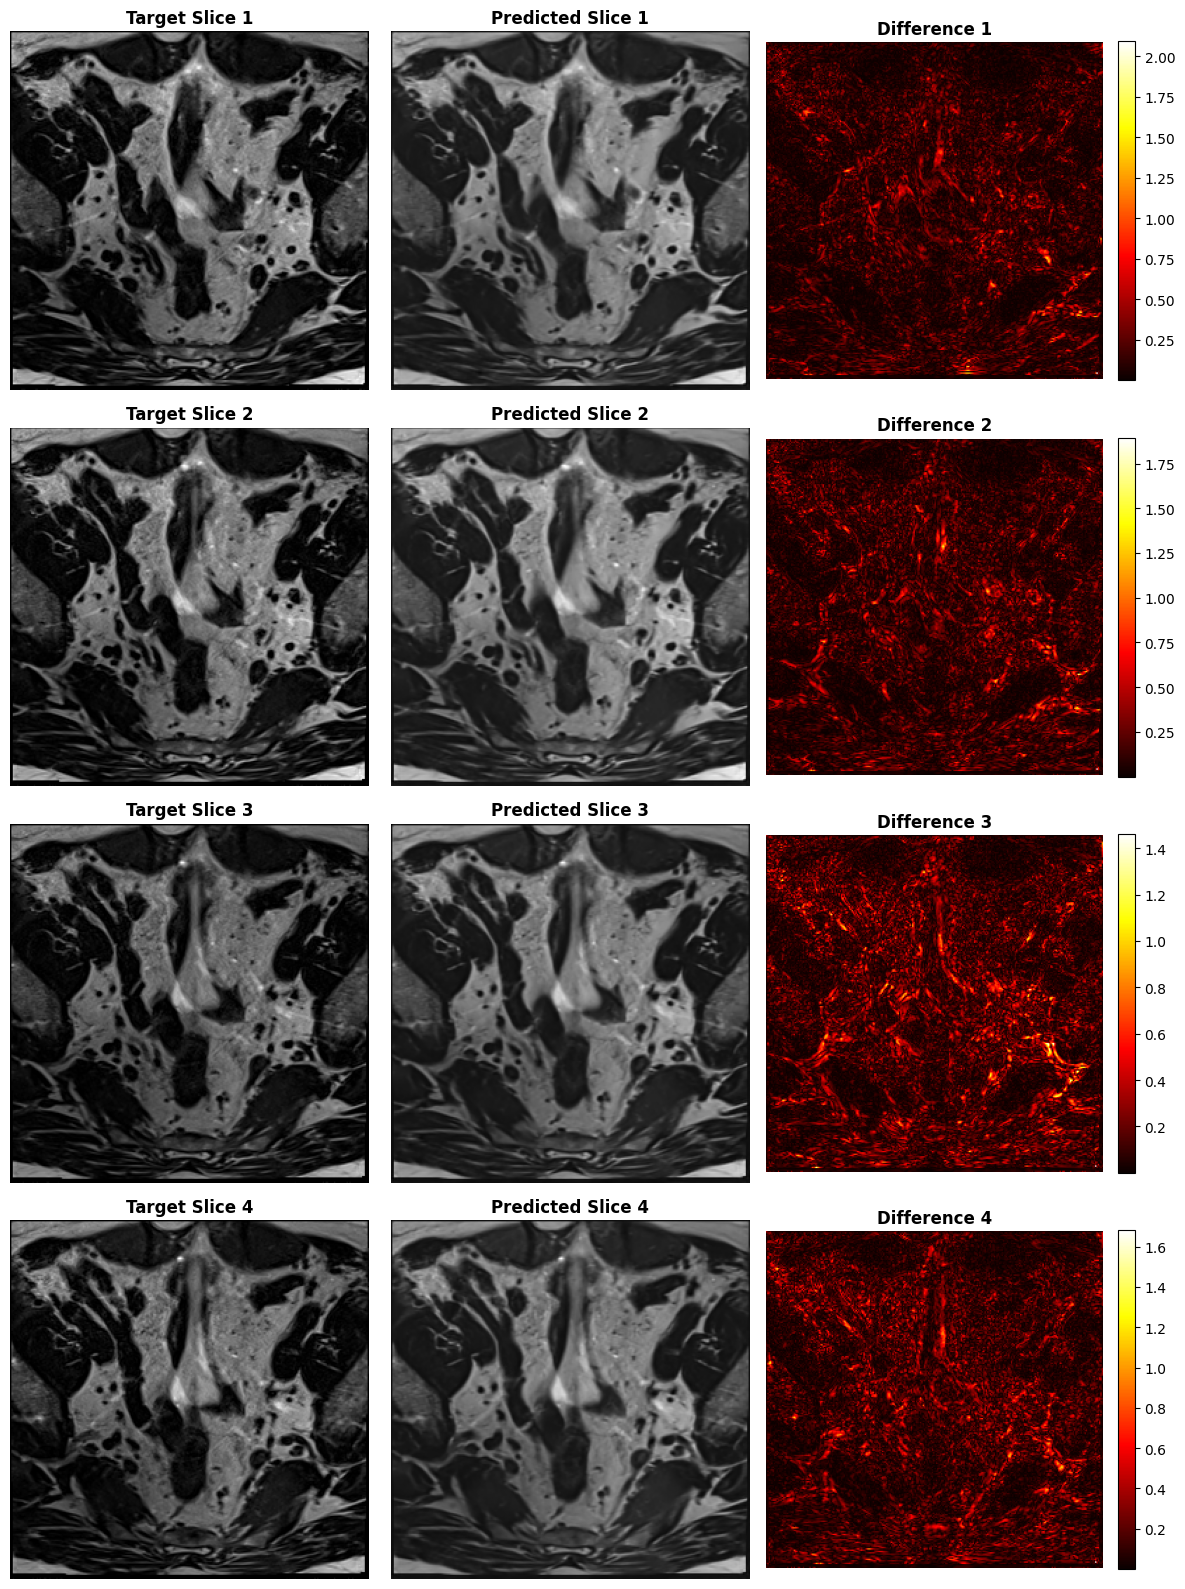

Predictions saved to ../models/deepcnn_predictions.png


In [10]:
# Concatenate all predictions and targets
all_predictions = torch.cat(predictions, dim=0)  # (N, 1, H, W)
all_targets = torch.cat(targets_list, dim=0)      # (N, 1, H, W)

# Visualize some predictions
n_samples = 4
fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))

for i in range(n_samples):
    pred = all_predictions[i, 0].numpy()
    target = all_targets[i, 0].numpy()
    diff = np.abs(pred - target)
    
    axes[i, 0].imshow(target, cmap='gray')
    axes[i, 0].set_title(f'Target Slice {i+1}', fontweight='bold')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(pred, cmap='gray')
    axes[i, 1].set_title(f'Predicted Slice {i+1}', fontweight='bold')
    axes[i, 1].axis('off')
    
    im = axes[i, 2].imshow(diff, cmap='hot')
    axes[i, 2].set_title(f'Difference {i+1}', fontweight='bold')
    axes[i, 2].axis('off')
    plt.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
pred_path = MODEL_SAVE_DIR / 'deepcnn_predictions.png'
plt.savefig(pred_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Predictions saved to {pred_path}")

# Compute Quality Metrics

In [11]:
# Calculate SSIM and PSNR scores
all_predictions_np = all_predictions.numpy()  # (N, 1, H, W)
all_targets_np = all_targets.numpy()          # (N, 1, H, W)

ssim_scores = []
psnr_scores = []

print("\n" + "="*70)
print("COMPUTING QUALITY METRICS FOR DeepCNN MODEL")
print("="*70)

for i in range(len(all_predictions_np)):
    pred = all_predictions_np[i, 0]  # (H, W)
    target = all_targets_np[i, 0]     # (H, W)
    
    # Calculate SSIM
    ssim_score = ssim(target, pred, data_range=pred.max() - pred.min())
    ssim_scores.append(ssim_score)
    
    # Calculate PSNR
    psnr_score = psnr(target, pred, data_range=pred.max() - pred.min())
    psnr_scores.append(psnr_score)

ssim_scores = np.array(ssim_scores)
psnr_scores = np.array(psnr_scores)

print(f"\n📊 DeepCNN MODEL - IMAGE QUALITY METRICS:")
print(f"\n{'Metric':<20} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
print(f"{'-'*68}")
print(f"{'SSIM':20} {ssim_scores.mean():<12.4f} {ssim_scores.std():<12.4f} {ssim_scores.min():<12.4f} {ssim_scores.max():<12.4f}")
print(f"{'PSNR (dB)':20} {psnr_scores.mean():<12.4f} {psnr_scores.std():<12.4f} {psnr_scores.min():<12.4f} {psnr_scores.max():<12.4f}")

print(f"\n📈 Per-Sample Metrics (first 10 samples):")
for i in range(min(10, len(ssim_scores))):
    print(f"   Sample {i+1:3d}: SSIM = {ssim_scores[i]:.4f}, PSNR = {psnr_scores[i]:.2f} dB")

if len(ssim_scores) > 10:
    print(f"   ... and {len(ssim_scores)-10} more samples")

print("\n" + "="*70)


COMPUTING QUALITY METRICS FOR DeepCNN MODEL

📊 DeepCNN MODEL - IMAGE QUALITY METRICS:

Metric               Mean         Std Dev      Min          Max         
--------------------------------------------------------------------
SSIM                 0.7159       0.1514       0.1966       0.9786      
PSNR (dB)            27.7270      4.1808       16.3524      47.0884     

📈 Per-Sample Metrics (first 10 samples):
   Sample   1: SSIM = 0.8503, PSNR = 29.02 dB
   Sample   2: SSIM = 0.8502, PSNR = 28.63 dB
   Sample   3: SSIM = 0.8553, PSNR = 29.53 dB
   Sample   4: SSIM = 0.8596, PSNR = 30.00 dB
   Sample   5: SSIM = 0.8438, PSNR = 28.53 dB
   Sample   6: SSIM = 0.8235, PSNR = 28.00 dB
   Sample   7: SSIM = 0.8034, PSNR = 28.63 dB
   Sample   8: SSIM = 0.8082, PSNR = 28.73 dB
   Sample   9: SSIM = 0.8215, PSNR = 29.18 dB
   Sample  10: SSIM = 0.8396, PSNR = 30.79 dB
   ... and 18230 more samples



# Training History & Summary

In [ ]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_deepcnn, label='Training Loss', linewidth=2, marker='o', markersize=3)
plt.plot(val_losses_deepcnn, label='Validation Loss', linewidth=2, marker='s', markersize=3)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.title('DeepCNN Training Progress', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_losses_deepcnn, label='Validation Loss', linewidth=2, color='orange')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.title('Validation Loss (Zoomed)', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = MODEL_SAVE_DIR / 'deepcnn_training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curves saved to {plot_path}")

In [ ]:
# Save training history
history = {
    'train_losses': train_losses_deepcnn,
    'val_losses': val_losses_deepcnn,
    'test_loss': test_loss,
    'best_val_loss': best_val_loss_deepcnn,
    'epochs_trained': len(train_losses_deepcnn),
    'metrics': {
        'ssim_mean': float(ssim_scores.mean()),
        'ssim_std': float(ssim_scores.std()),
        'psnr_mean': float(psnr_scores.mean()),
        'psnr_std': float(psnr_scores.std())
    },
    'config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'early_stopping_patience': EARLY_STOPPING_PATIENCE,
        'augmentation': AUGMENT,
        'architecture': 'DeepCNN ResNet-style',
        'base_features': 64,
        'num_blocks': [2, 2, 2, 2]
    },
    'timestamp': datetime.now().isoformat()
}

log_path = MODEL_SAVE_DIR / 'deepcnn_history.json'
with open(log_path, 'w') as f:
    json.dump(history, f, indent=4)

print(f"Training history saved to {log_path}")

print(f"\n" + "="*70)
print("DeepCNN TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\nTraining Summary:")
print(f"   Model: DeepCNN (ResNet-style, 4 residual layers)")
print(f"   Epochs trained: {len(train_losses_deepcnn)}")
print(f"   Best validation loss: {best_val_loss_deepcnn:.4f}")
print(f"   Final test loss: {test_loss:.4f}")
print(f"\nQuality Metrics:")
print(f"   SSIM: {ssim_scores.mean():.4f} ± {ssim_scores.std():.4f}")
print(f"   PSNR: {psnr_scores.mean():.2f} ± {psnr_scores.std():.2f} dB")
print(f"\nCheckpoint Directory: {CHECKPOINT_DIR_DEEPCNN}")
print(f"Models saved to: {MODEL_SAVE_DIR}")
print("="*70)